In [ ]:
import numpy as np
import matplotlib.pyplot as mplt
import pandas as pd

from google.colab import files
!pip install opendatasets
import opendatasets as od
import os

import tensorflow as tf
import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

###We import our first dataset:

In [ ]:
#We create a folder to store the data
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [ ]:
#we download the dataset
od.download("https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp/download?datasetVersionNumber=1")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: franckdzoupet
Your Kaggle Key: ··········


100%|██████████| 691M/691M [00:09<00:00, 80.4MB/s]


In [ ]:
#Now we unzip our file and remove all useless one
!unzip dog_dataset/dogbreedidfromcomp -d dog_dataset

unzip:  cannot find or open dog_dataset/dogbreedidfromcomp, dog_dataset/dogbreedidfromcomp.zip or dog_dataset/dogbreedidfromcomp.ZIP.


###Now we need to get an overview of our datas

In [ ]:
labels = pd.read_csv("/content/dog_dataset/dogbreedidfromcomp/labels.csv")
print("number of images:", len(labels))
print(labels.head())


number of images: 10222
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
breeds = labels["breed"].value_counts()
print("All breeds present :\n",breeds)

All breeds present :
 scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64


###We will select just a few classes for our exercice due to computational power

In [ ]:
class_selected = ["afghan_hound", "eskimo_dog", "golden_retriever", "briard"]
labels_restricted = labels[labels.breed.isin(class_selected)]
labels_restricted = labels_restricted.reset_index()
print(labels_restricted)

     index                                id             breed
0        4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
1       25  00a366d4b4a9bbb6c8a63126697b7656  golden_retriever
2       37  0100f55e4f0fe28f2c0465d3fc4b9897  golden_retriever
3      127  02ff77af410e966b7b661f6f0789d947  golden_retriever
4      146  0379145880ad3978f9b80f0dc2c03fba      afghan_hound
..     ...                               ...               ...
310   9964  fa2a33c1dc8b39ad51738408b289a0de            briard
311  10018  fb542f35faf7843778cb2c35d81a7a44        eskimo_dog
312  10172  febcab8eb2da444bf83336cffec7eb92  golden_retriever
313  10198  ff6f47aa8e181b6efa4d0be7b09b5628  golden_retriever
314  10214  ffcb610e811817766085054616551f9c            briard

[315 rows x 3 columns]


In [ ]:
breeds_ = labels_restricted["breed"].value_counts()
print("All breeds present :\n",breeds_)

All breeds present :
 afghan_hound        116
golden_retriever     67
eskimo_dog           66
briard               66
Name: breed, dtype: int64


###Normalisation


In [ ]:
from keras.utils.image_utils import img_to_array
from keras.utils import load_img

y_data = label_binarize(labels_restricted.breed, classes=class_selected)
x_data = np.zeros((len(y_data), 224, 224,3), dtype="float64")

for i in range(len(labels_restricted)):
  img = load_img("/content/dog_dataset/dogbreedidfromcomp/train/%s.jpg" % labels_restricted["id"][i],
                       target_size=(224, 224)
                       )
  img = img_to_array(img)
  x = np.expand_dims(img.copy(), axis=0)#This line adds an extra dimension to the array x, which represent the batch
  #along the specified axis. In this case, it adds an extra dimension at axis 0, effectively creating 315 batchs of size 1.
  x_data[i] = x / 255.0

#Normalisation


print("Shape of our train datas: {}\nShape of our labels: {}".format(x_data.shape, y_data.shape))

Shape of our train datas: (315, 224, 224, 3)
Shape of our labels: (315, 4)


###We create our model

In [ ]:
model = tf.keras.models.Sequential()
#conv2D : 2 Dimensional convulational model.
#32 : Input for next layer
#(3,3) : convolutional windows Size of the kernel

#1rst layer
model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=( 224, 224, 3)))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#2nd layer
model.add(tf.keras.layers.Conv2D(32, (3,3), kernel_regularizer="L2"))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#3rd layer
model.add(tf.keras.layers.Conv2D(16, (3,3), kernel_regularizer="l2"))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#4th layer
model.add(tf.keras.layers.Conv2D(8, (3,3), kernel_regularizer="l2"))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(124, activation="relu", kernel_regularizer="l2"))
model.add(tf.keras.layers.Dense(64, activation="relu", kernel_regularizer="l2"))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(4, activation="softmax",kernel_regularizer="l2"))#last layer



In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])#When you have more classes, use loss="sparse_catergorical_classentropy"

In [ ]:
model.summary()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

In [ ]:
epochs = 29
batch_size = 32
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/29
8/8 [==============================] - 38s 4s/step - loss: 2.9680 - accuracy: 0.5040
Epoch 2/29
8/8 [==============================] - 35s 4s/step - loss: 2.8266 - accuracy: 0.5675
Epoch 3/29
8/8 [==============================] - 36s 5s/step - loss: 2.8423 - accuracy: 0.5992
Epoch 4/29
8/8 [==============================] - 36s 4s/step - loss: 2.7933 - accuracy: 0.6071
Epoch 5/29
8/8 [==============================] - 48s 6s/step - loss: 2.8058 - accuracy: 0.5873
Epoch 6/29
8/8 [==============================] - 36s 4s/step - loss: 2.7248 - accuracy: 0.6071
Epoch 7/29
8/8 [==============================] - 36s 4s/step - loss: 2.6928 - accuracy: 0.6468
Epoch 8/29
8/8 [==============================] - 37s 5s/step - loss: 2.6374 - accuracy: 0.6468
Epoch 9/29
8/8 [==============================] - 36s 5s/step - loss: 2.5941 - accuracy: 0.6667
Epoch 10/29
8/8 [==============================] - 36s 5s/step - loss: 2.6009 - accuracy: 0.6151
Epoch 11/29
8/8 [======================

###Now we will plot the training history

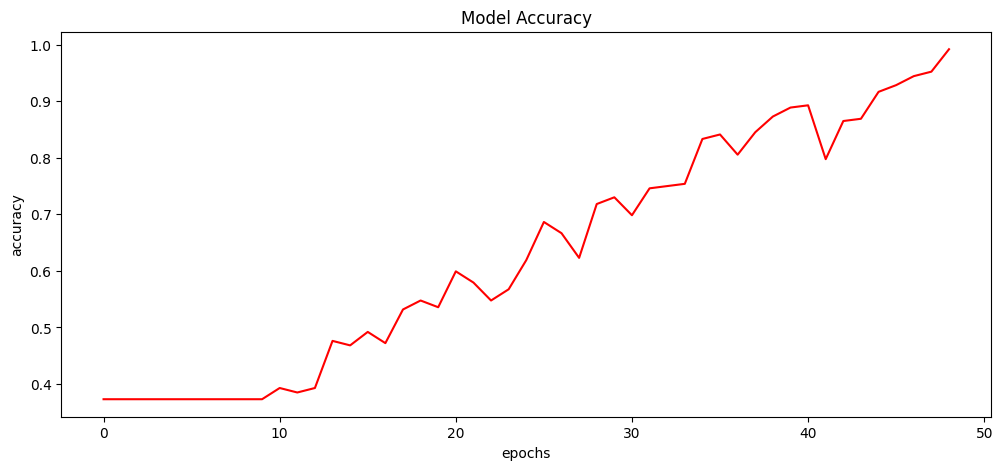

In [ ]:
mplt.figure(figsize= (12,5))
mplt.plot(history.history["accuracy"], color="r")
mplt.title("Model Accuracy")
mplt.ylabel("accuracy")
mplt.xlabel("epochs")

mplt.show()

In [ ]:
y_pred = model.predict(x_test)
score = model.evaluate(x_test, y_test)
print("accuracy of our model: {}%".format(round(score[1]*100, 3)))
print(score)

2/2 [==============================] - 2s 906ms/step - loss: 2.8075 - accuracy: 0.3968
accuracy of our model: 39.683%
[2.807501792907715, 0.3968254029750824]


Original: golden_retriever
Predicted: golden_retriever
Original: afghan_hound
Predicted: golden_retriever
Original: eskimo_dog
Predicted: golden_retriever
Original: golden_retriever
Predicted: golden_retriever
Original: afghan_hound
Predicted: golden_retriever
Original: eskimo_dog
Predicted: golden_retriever
Original: golden_retriever
Predicted: golden_retriever
Original: golden_retriever
Predicted: golden_retriever
Original: golden_retriever
Predicted: golden_retriever
Original: golden_retriever
Predicted: golden_retriever


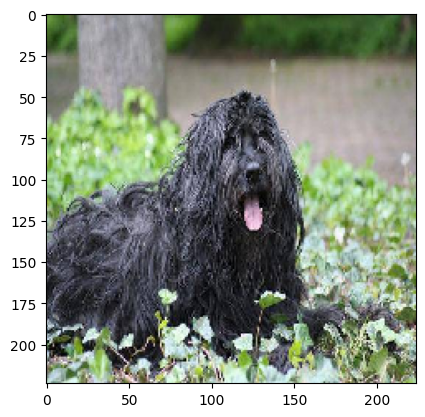

In [ ]:
import random
from keras.backend import random_uniform
for i in range(10):
  plt.subplot(2, 5, i)
  rd = random.randint( 0, len(y_test))
  img = x_test[rd, :,:,:]

  mplt.imshow(img)
  mplt.title("plot{}".format(i))
  print("Original: {}".format(labels_restricted['breed'][rd]))
  print("Predicted: {}".format(labels_restricted["breed"][np.argmax(y_pred[rd])]))

mplt.show()

###We save our model

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Save the model
model.save('/content/drive/MyDrive/dog_breed_id_model')

Mounted at /content/drive


In [ ]:
#Load a save model format
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/dog_breed_id_model")
loaded_model.summary()
'sometimes you might have to squezze your model with loaded_model.squezze '

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 activation (Activation)     (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                    

'sometimes you might have to squezze your model with loaded_model.squezze '

In [ ]:
y_pred = loaded_model.predict(x_test)
score = loaded_model.evaluate(x_test, y_test)
print("accuracy of our model: {}%".format(round(score[1]*100, 3)))
print(score)

2/2 [==============================] - 4s 2s/step - loss: 2.8075 - accuracy: 0.3968
accuracy of our model: 39.683%
[2.807501792907715, 0.3968254029750824]
